In [1]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras tuner
# import keras_tuner
# from keras_tuner import RandomSearch
# from keras_tuner.engine.hyperparameters import HyperParameters

#transfer learning
from tensorflow.keras.applications.resnet50 import ResNet50


#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

2024-04-13 12:20:52.631601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 12:20:53.614257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


we are currently using tensorflow version 2.13.0


In [2]:
train_dir = r'data/RiceLeafsDisease/train/'
test_dir = r'data/RiceLeafsDisease/validation/'

val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [3]:
BATCH_SIZE = 16
seeds = 41
im_shape = (250,250)

In [4]:
# Load and preprocess the training data
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True)

# Generator of Train
train_generator = train_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=True, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")
# Generator of validation
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="validation")

# Generator of dataset test
test_generator = test_generator.flow_from_directory(test_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)


Found 1680 images belonging to 6 classes.
Found 420 images belonging to 6 classes.
Found 528 images belonging to 6 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


## ResNet50

In [5]:
resnet50 = keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(250,250,3))

for layer in resnet50.layers:
    layer.trainable=False

resnet_model = Sequential()
resnet_model.add(resnet50)
resnet_model.add(BatchNormalization())
resnet_model.add(GlobalAveragePooling2D())
# resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(2048, activation='relu'))
# resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(6, activation='softmax'))
resnet_model.summary()

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2024-04-13 12:21:05.572976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 12:21:05.584832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 12:21:05.585098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 batch_normalization (Batch  (None, 8, 8, 2048)        8192      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 27804550 (106.07 MB)
Trainable params: 421

In [6]:
import time
# Record the start time of training
start_time = time.time()

In [7]:
# Train the model
epochs = 10

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='resnet50_model_16batchsize.h5',
        monitor='val_loss', save_best_only=True, verbose=1)
]


#Training
resnet_history = resnet_model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // 16,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // 16)

Epoch 1/10


2024-04-13 12:21:28.196138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-13 12:21:29.274742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-13 12:21:30.026047: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1d4beac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-13 12:21:30.026150: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-13 12:21:30.037656: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-13 12:21:30.231120: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

105/105 [==============================] - ETA: 0s - loss: 1.4765 - accuracy: 0.4315
Epoch 1: val_loss improved from inf to 2.60473, saving model to resnet50_model_16batchsize.h5
105/105 [==============================] - 59s 494ms/step - loss: 1.4765 - accuracy: 0.4315 - val_loss: 2.6047 - val_accuracy: 0.1947
Epoch 2/10
105/105 [==============================] - ETA: 0s - loss: 1.1877 - accuracy: 0.5357
Epoch 2: val_loss improved from 2.60473 to 1.58610, saving model to resnet50_model_16batchsize.h5
105/105 [==============================] - 51s 485ms/step - loss: 1.1877 - accuracy: 0.5357 - val_loss: 1.5861 - val_accuracy: 0.3846
Epoch 3/10
105/105 [==============================] - ETA: 0s - loss: 1.1478 - accuracy: 0.5601
Epoch 3: val_loss improved from 1.58610 to 1.24362, saving model to resnet50_model_16batchsize.h5
105/105 [==============================] - 50s 478ms/step - loss: 1.1478 - accuracy: 0.5601 - val_loss: 1.2436 - val_accuracy: 0.5048
Epoch 4/10
105/105 [===========

In [8]:
# Record the training end time
end_time = time.time()

In [9]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 529.9948725700378 seconds


In [10]:
pd.DataFrame(resnet_history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.476515,0.431548,2.604727,0.194712
1,1.187744,0.535714,1.586101,0.384615
2,1.147760,0.560119,1.243620,0.504808
3,1.076735,0.583333,1.147753,0.555288
4,1.021393,0.604762,1.132639,0.552885
5,0.939722,0.636905,1.196603,0.596154
6,0.987438,0.615476,1.174634,0.569712
7,0.920415,0.650595,1.155720,0.586538
8,0.878177,0.663690,1.138375,0.574519
9,0.906879,0.655357,0.989089,0.658654


In [11]:
import joblib

joblib.dump(resnet_history.history,'history_ResNet50_DA_16batchsize.pkl')
resnet_history = joblib.load('history_ResNet50_DA_16batchsize.pkl')

In [12]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

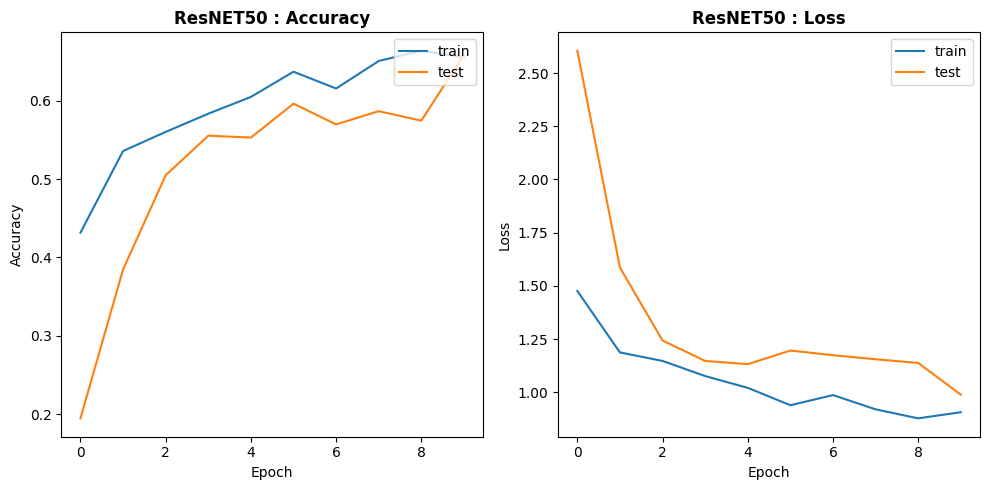

In [13]:
plot_performance(model_name='ResNET50',
                acc=resnet_history['accuracy'], 
                 val_acc=resnet_history['val_accuracy'],
                 loss=resnet_history['loss'], 
                 val_loss=resnet_history['val_loss'])

In [14]:
# Load the best saved model
from keras.models import load_model

model_1 = load_model('resnet50_model_16batchsize.h5')
score = model_1.evaluate(validation_generator)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('\nVal loss:', score[0])
print('Val accuracy:', score[1])

score = model_1.evaluate(test_generator)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

test_loss.append(score[0])
test_accuracy.append(score[1])

27/27 [==============================] - 12s 390ms/step - loss: 1.0283 - accuracy: 0.6452

Val loss: 1.0282535552978516
Val accuracy: 0.6452381014823914
33/33 [==============================] - 12s 372ms/step - loss: 0.8370 - accuracy: 0.6875

Test loss: 0.8369970321655273
Test accuracy: 0.6875


In [15]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

33/33 [==============================] - 14s 396ms/step
Classification Report
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.74      0.90      0.81        88
           brown_spot       0.57      0.41      0.48        88
              healthy       0.70      0.84      0.77        88
           leaf_blast       0.61      0.32      0.42        88
           leaf_scald       0.75      0.81      0.78        88
    narrow_brown_spot       0.63      0.81      0.71        88

             accuracy                           0.68       528
            macro avg       0.67      0.68      0.66       528
         weighted avg       0.67      0.68      0.66       528



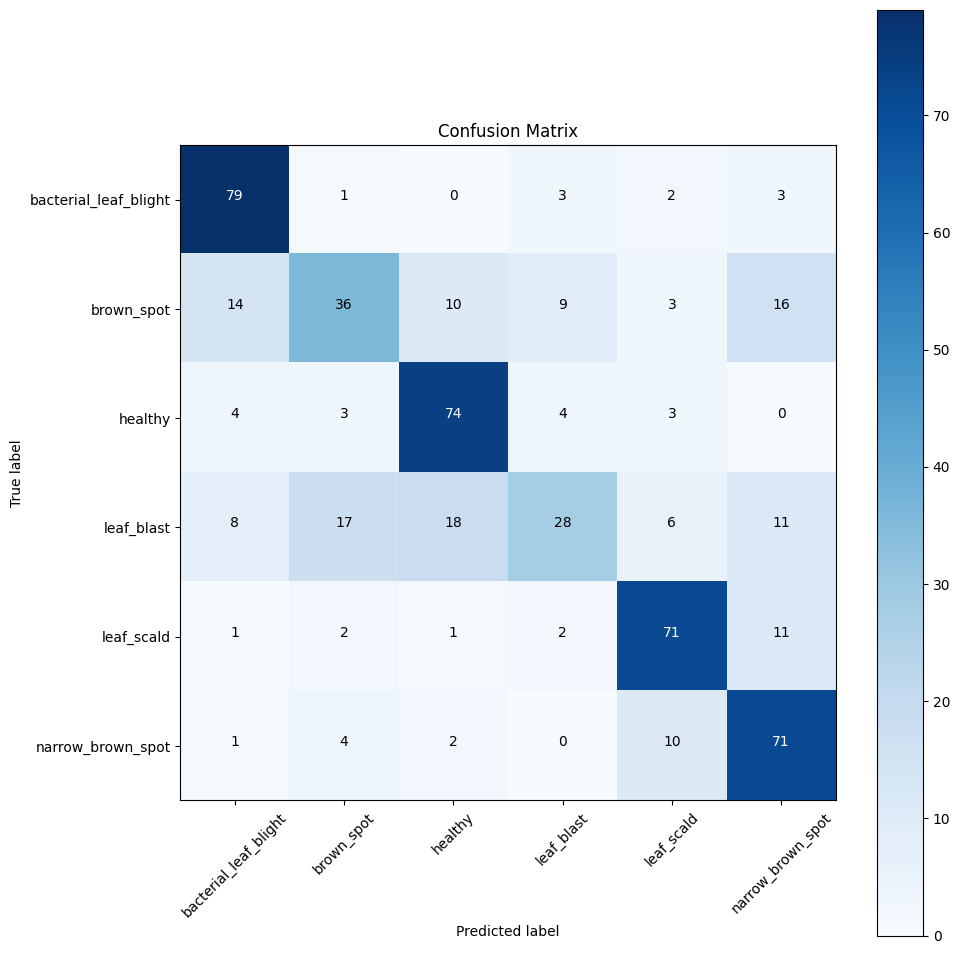

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model_1.predict(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, zero_division=1))

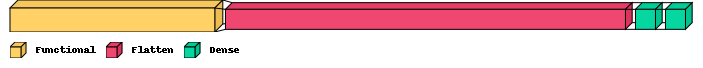

In [24]:
import visualkeras

visualkeras.layered_view(resnet_model,  legend=True)